In [1]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods
from sklearn.utils import resample
import math

In [2]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [7]:
n_features = 300
X, y = make_classification(n_samples = 2000, n_features = n_features, n_informative = 100, n_clusters_per_class=10, n_redundant=100, n_repeated=0, flip_y=0.01, random_state=2, class_sep=3)
X_train, X_test = np.split(X, [500])
y_train, y_test = np.split(y, [500])
data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Random selection

In [4]:
@time_func
def RANDOM_SELECTION(CVal = 0.1, kernel='liblinear', w1 = [0.8, 0.2]):
    data.kernel = kernel
    data.C = CVal
    with Pool(7) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1)

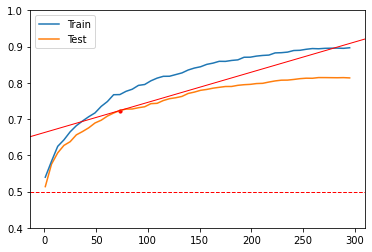

AT (73, 0.7236, 0.2697866666666667) WITH 0 ITERATIONS IN -1 SECONDS : -1
__main__.RANDOM_SELECTION - 00:00:03.957231500


In [5]:
RANDOM_SELECTION(0.00001)

# SVM-RFE

In [4]:
@time_func
def SVM_RFE_W_STEP(step = 10, percentage = 0.5, C = 0.5, kernel = 'liblinear', w1 = [0.8, 0.2], gamma = 1.0, degree=6, sampling_p = 0.5, dstep_p = 0.1, dstop = 1):
    data.kernel = 'precomputed'
    data.kernel_matrix = kernel
    data.C = C
    data.gamma = gamma
    data.degree = degree
    data.sampling_percentagee = sampling_p
    data.dstep_percentage = dstep_p
    data.dstop = dstop
    kf = KFold(n_splits=7, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_combo, index)

    #scores = list(map(data.svm_rfe_kernel, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    all_scores = [scal(x[1], w1)[2] for x in scores]
    err = np.std(all_scores, ddof=1) / np.sqrt(np.size(all_scores))

    print(kernel, C, degree, gamma)
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    return scal(test_scores, w1), time, (np.mean(all_scores), err)

poly 1e-06 2 1.0


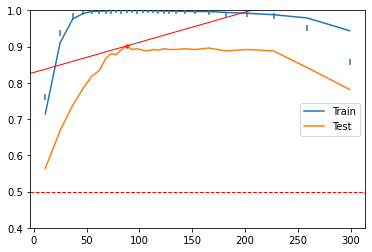

AT (88, 0.901939414263358, 0.1371151352559803) WITH 28 ITERATIONS IN 7.7180016040802 SECONDS : 0.03727304264383032
__main__.SVM_RFE_W_STEP - 00:00:10.809320800


((88, 0.901939414263358, 0.1371151352559803),
 7.7180016040802,
 (0.12079052090319697, 0.009649156738581837))

In [20]:
SVM_RFE_W_STEP(kernel='poly', degree=2, C=10**-6, dstop=100, dstep_p=0.2, sampling_p=1.0, step=5)

poly 1e-06 2 1.0


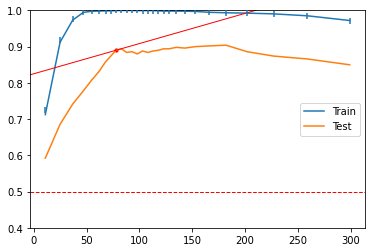

AT (78, 0.8899787614576348, 0.14001699083389219) WITH 28 ITERATIONS IN 12.276853220803398 SECONDS : 0.15549875835256213
__main__.SVM_RFE_W_STEP - 00:00:15.807224100


((78, 0.8899787614576348, 0.14001699083389219),
 12.276853220803398,
 (0.1275689693717863, 0.01289577829914507))

In [18]:
SVM_RFE_W_STEP(kernel='poly', degree=2, C=10**-6, dstop=100, dstep_p=0.2, sampling_p=0.7, step=5)

poly 1e-10 1 1.0


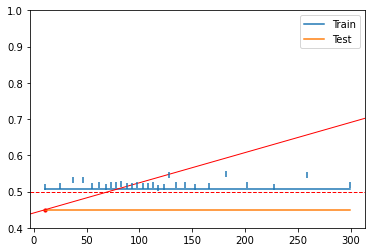

AT (11, 0.4500614799910574, 0.4472841493404875) WITH 28 ITERATIONS IN 8.003283977508545 SECONDS : 0.023606083883610803
__main__.SVM_RFE_W_STEP - 00:00:10.837201100
poly 1e-09 1 1.0


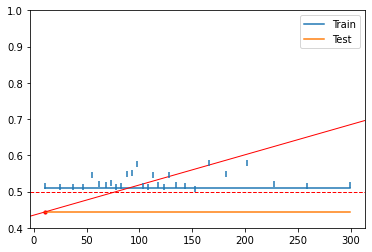

AT (11, 0.44402526268723447, 0.45211312318354574) WITH 28 ITERATIONS IN 7.922711985451834 SECONDS : 0.03337813589090107
__main__.SVM_RFE_W_STEP - 00:00:10.870364000
poly 1e-08 1 1.0


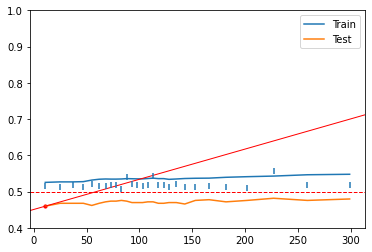

AT (11, 0.45970266040688573, 0.4395712050078248) WITH 28 ITERATIONS IN 7.928857530866351 SECONDS : 0.018626680690422108
__main__.SVM_RFE_W_STEP - 00:00:10.793307200
poly 1e-07 1 1.0


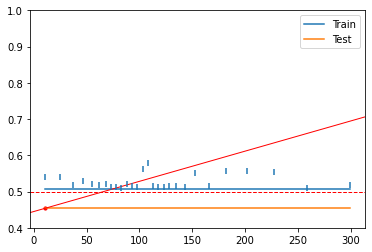

AT (11, 0.4539738430583501, 0.44415425888665333) WITH 28 ITERATIONS IN 8.075572729110718 SECONDS : 0.010070570469549369
__main__.SVM_RFE_W_STEP - 00:00:10.879417400
poly 1e-06 1 1.0


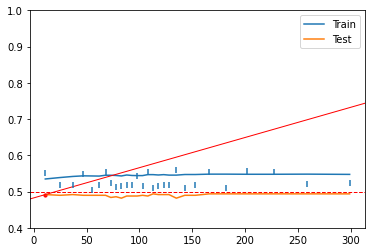

AT (11, 0.49167225575676277, 0.41399552872792317) WITH 28 ITERATIONS IN 8.035569429397583 SECONDS : 0.016888229381152087
__main__.SVM_RFE_W_STEP - 00:00:10.874166600
poly 1e-05 1 1.0


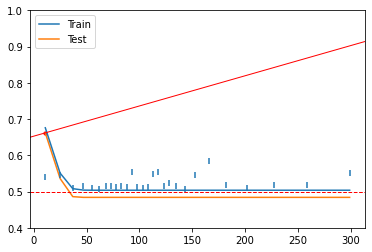

AT (11, 0.6619718309859154, 0.27775586854460105) WITH 28 ITERATIONS IN 8.198283876691546 SECONDS : 0.04211573785433219
__main__.SVM_RFE_W_STEP - 00:00:11.071573700
poly 0.0001 1 1.0


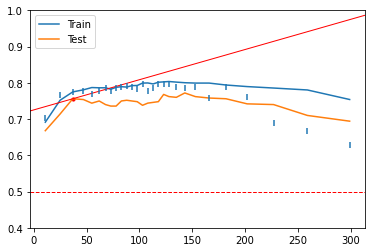

AT (37, 0.7560921082047843, 0.2197929801028392) WITH 28 ITERATIONS IN 7.95671466418675 SECONDS : 0.02688870025869795
__main__.SVM_RFE_W_STEP - 00:00:10.835860700
poly 0.001 1 1.0


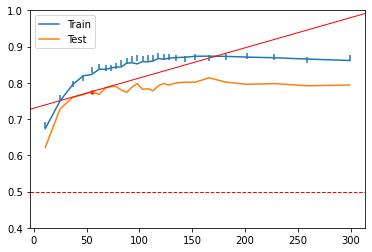

AT (55, 0.7758215962441316, 0.2160093896713614) WITH 28 ITERATIONS IN 6.849854843957083 SECONDS : 0.024376419200228955
__main__.SVM_RFE_W_STEP - 00:00:09.794527400
poly 0.01 1 1.0


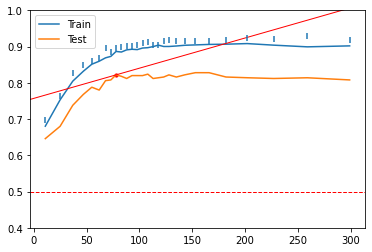

AT (78, 0.8220433713391458, 0.19436530292868331) WITH 28 ITERATIONS IN 6.134857245853969 SECONDS : 0.045169771985581746
__main__.SVM_RFE_W_STEP - 00:00:09.549728500
poly 0.1 1 1.0


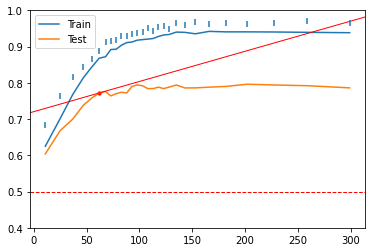

AT (62, 0.7720489604292421, 0.22369416498993966) WITH 28 ITERATIONS IN 5.541427646364484 SECONDS : 0.06981929503723333
__main__.SVM_RFE_W_STEP - 00:00:08.870218500
poly 1e-10 2 1.0


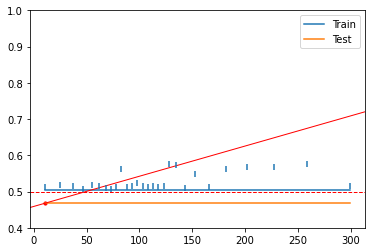

AT (11, 0.4680583501006036, 0.43288665325285053) WITH 28 ITERATIONS IN 8.314854247229439 SECONDS : 0.007987888286978126
__main__.SVM_RFE_W_STEP - 00:00:11.347738400
poly 1e-09 2 1.0


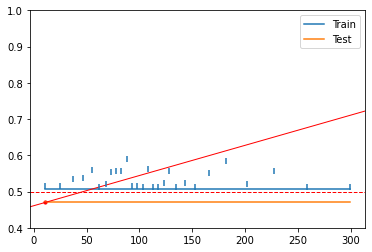

AT (11, 0.4700424770847306, 0.43129935166554884) WITH 28 ITERATIONS IN 8.231998750141688 SECONDS : 0.012811610820201203
__main__.SVM_RFE_W_STEP - 00:00:11.092844800
poly 1e-08 2 1.0


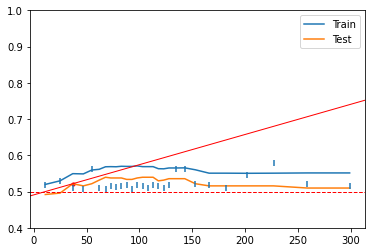

AT (37, 0.5216297786720321, 0.407362843729041) WITH 28 ITERATIONS IN 8.341141496385847 SECONDS : 0.042012056596091696
__main__.SVM_RFE_W_STEP - 00:00:11.229914000
poly 1e-07 2 1.0


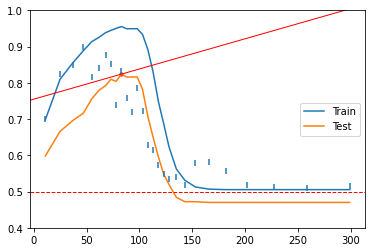

AT (83, 0.8240554437737538, 0.19608897831433028) WITH 28 ITERATIONS IN 8.506288017545428 SECONDS : 0.0021189007290271246
__main__.SVM_RFE_W_STEP - 00:00:11.349515600
poly 1e-06 2 1.0


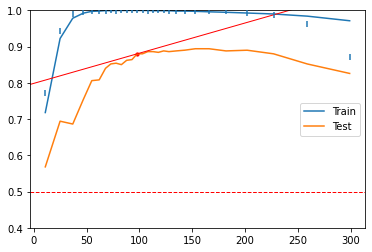

AT (98, 0.8801140174379611, 0.16124211938296446) WITH 28 ITERATIONS IN 7.961857284818377 SECONDS : 0.0481812497811953
__main__.SVM_RFE_W_STEP - 00:00:11.002435000
poly 1e-05 2 1.0


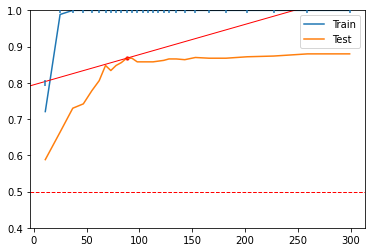

AT (88, 0.867901855577912, 0.16434518220433708) WITH 28 ITERATIONS IN 7.8344283785138815 SECONDS : 0.005384669869982292
__main__.SVM_RFE_W_STEP - 00:00:10.853478100
poly 0.0001 2 1.0


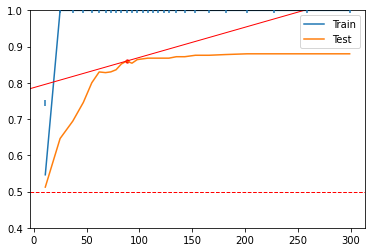

AT (88, 0.8601050748938072, 0.17058260675162096) WITH 28 ITERATIONS IN 7.739996944155012 SECONDS : 0.0398929797618398
__main__.SVM_RFE_W_STEP - 00:00:10.836117900
poly 0.001 2 1.0


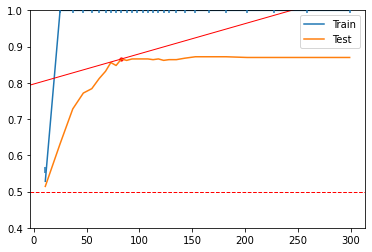

AT (83, 0.8658618376928235, 0.1626438631790745) WITH 28 ITERATIONS IN 7.851713827678135 SECONDS : 0.015096830289552119
__main__.SVM_RFE_W_STEP - 00:00:10.789783500
poly 0.01 2 1.0


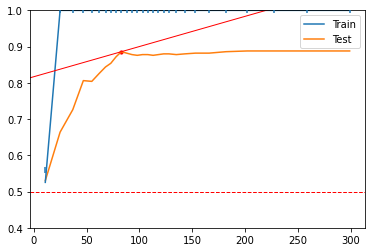

AT (83, 0.8859546165884192, 0.14656964006259796) WITH 28 ITERATIONS IN 8.189285108021327 SECONDS : 0.0176034719109
__main__.SVM_RFE_W_STEP - 00:00:11.134359600
poly 0.1 2 1.0


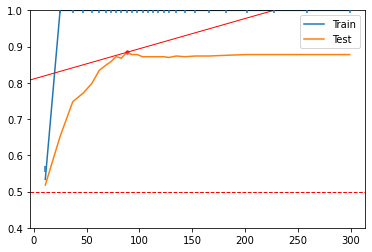

AT (88, 0.8840822714062151, 0.1514008495416946) WITH 28 ITERATIONS IN 8.097142083304268 SECONDS : 0.018851099925912572
__main__.SVM_RFE_W_STEP - 00:00:11.155235000
poly 1e-10 3 1.0


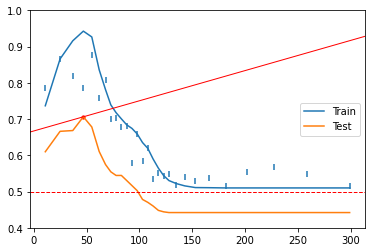

AT (47, 0.706293315448245, 0.2662986809747373) WITH 28 ITERATIONS IN 8.781285320009504 SECONDS : 0.0018984099892712
__main__.SVM_RFE_W_STEP - 00:00:11.897279500
poly 1e-09 3 1.0


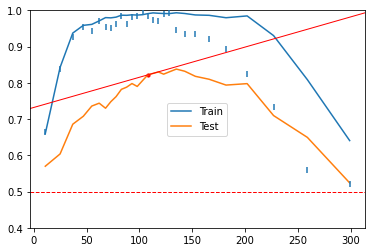

AT (108, 0.8219874804381847, 0.21441001564945222) WITH 28 ITERATIONS IN 8.67099744932992 SECONDS : 0.01658688515580048
__main__.SVM_RFE_W_STEP - 00:00:11.788804300
poly 1e-08 3 1.0


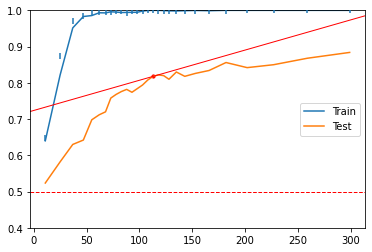

AT (113, 0.8178794992175273, 0.22102973395931147) WITH 28 ITERATIONS IN 8.64613859994071 SECONDS : 0.03234079968715563
__main__.SVM_RFE_W_STEP - 00:00:11.839023600
poly 1e-07 3 1.0


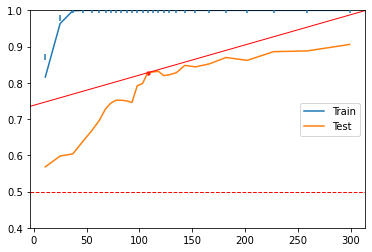

AT (108, 0.827995752291527, 0.20960339816677842) WITH 28 ITERATIONS IN 8.523981537137713 SECONDS : 0.002834537980470951
__main__.SVM_RFE_W_STEP - 00:00:11.709142900
poly 1e-06 3 1.0


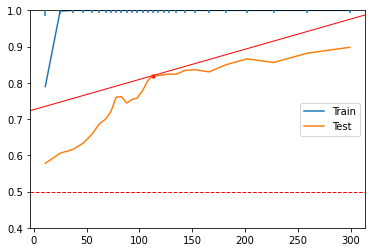

AT (113, 0.8201710261569417, 0.21919651240778) WITH 28 ITERATIONS IN 8.4534250327519 SECONDS : 0.038687080042935265
__main__.SVM_RFE_W_STEP - 00:00:12.030800200
poly 1e-05 3 1.0


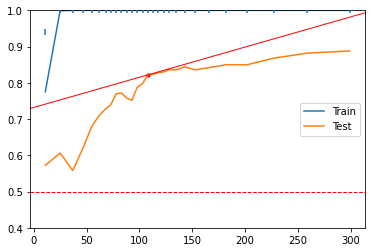

AT (108, 0.8219874804381847, 0.21441001564945222) WITH 28 ITERATIONS IN 8.525424446378436 SECONDS : 0.02197606595179924
__main__.SVM_RFE_W_STEP - 00:00:11.779227900
poly 0.0001 3 1.0


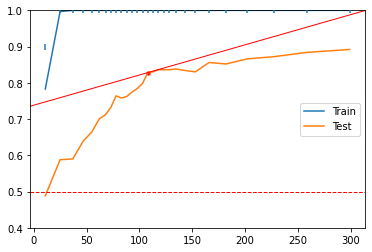

AT (108, 0.8282472613458529, 0.2094021909233177) WITH 28 ITERATIONS IN 8.571995462690081 SECONDS : 0.0202864053907925
__main__.SVM_RFE_W_STEP - 00:00:11.901180100
poly 0.001 3 1.0


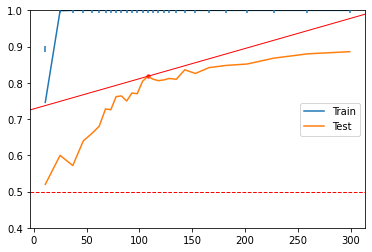

AT (108, 0.818075117370892, 0.21753990610328638) WITH 28 ITERATIONS IN 8.4611451285226 SECONDS : 0.03778025012884799
__main__.SVM_RFE_W_STEP - 00:00:11.926916100
poly 0.01 3 1.0


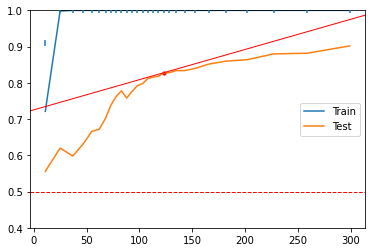

AT (123, 0.8278839704896043, 0.2196928236083166) WITH 28 ITERATIONS IN 8.510057892118182 SECONDS : 0.034812083649828254
__main__.SVM_RFE_W_STEP - 00:00:11.771237400
poly 0.1 3 1.0


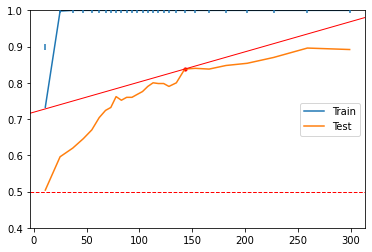

AT (143, 0.8381120053655265, 0.2248437290409121) WITH 28 ITERATIONS IN 8.582566397530693 SECONDS : 0.026182560337553454
__main__.SVM_RFE_W_STEP - 00:00:11.893546800


In [21]:
model_selection = {}
for d in [1, 2, 3]:
    for C in [10**-10, 10**-9, 10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1]:
        model_selection[C, d] = SVM_RFE_W_STEP(kernel='poly', degree=d, C=C, dstop=100, dstep_p=0.2, sampling_p=0.7, step=5)

In [22]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.0e}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {1: 1, 2: 2, 3: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "  {:>3s} & {:.2f}\\% & {:.3f}".format(str(v[0][0]), 100 * v[0][1], v[0][2])

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{1e-10} &    11 & 45.01\% & 0.447 &    11 & 46.81\% & 0.433 &    47 & 70.63\% & 0.266\\
\textbf{1e-09} &    11 & 44.40\% & 0.452 &    11 & 47.00\% & 0.431 &   108 & 82.20\% & 0.214\\
\textbf{1e-08} &    11 & 45.97\% & 0.440 &    37 & 52.16\% & 0.407 &   113 & 81.79\% & 0.221\\
\textbf{1e-07} &    11 & 45.40\% & 0.444 &    83 & 82.41\% & 0.196 &   108 & 82.80\% & 0.210\\
\textbf{1e-06} &    11 & 49.17\% & 0.414 &    98 & 88.01\% & 0.161 &   113 & 82.02\% & 0.219\\
\textbf{1e-05} &    11 & 66.20\% & 0.278 &    88 & 86.79\% & 0.164 &   108 & 82.20\% & 0.214\\
\textbf{1e-04} &    37 & 75.61\% & 0.220 &    88 & 86.01\% & 0.171 &   108 & 82.82\% & 0.209\\
\textbf{1e-03} &    55 & 77.58\% & 0.216 &    83 & 86.59\% & 0.163 &   108 & 81.81\% & 0.218\\
\textbf{1e-02} &    78 & 82.20\% & 0.194 &    83 & 88.60\% & 0.147 &   123 & 82.79\% & 0.220\\
\textbf{1e-01} &    62 & 77.20\% & 0.224 &    88 & 88.41\% & 0.151 &   143 & 83.81\% & 0.225\\


In [23]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.0e}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {1: 1, 2: 2, 3: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "{:.0f}:{:0>2s}.{:0>3s}".format(math.floor(v[1]/60.0), str(int(v[1] % 60)), str(int((v[1] % 1) * 1000)))

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{1e-10} & 0:08.003 & 0:08.314 & 0:08.781\\
\textbf{1e-09} & 0:07.922 & 0:08.231 & 0:08.670\\
\textbf{1e-08} & 0:07.928 & 0:08.341 & 0:08.646\\
\textbf{1e-07} & 0:08.075 & 0:08.506 & 0:08.523\\
\textbf{1e-06} & 0:08.035 & 0:07.961 & 0:08.453\\
\textbf{1e-05} & 0:08.198 & 0:07.834 & 0:08.525\\
\textbf{1e-04} & 0:07.956 & 0:07.739 & 0:08.571\\
\textbf{1e-03} & 0:06.849 & 0:07.851 & 0:08.461\\
\textbf{1e-02} & 0:06.134 & 0:08.189 & 0:08.510\\
\textbf{1e-01} & 0:05.541 & 0:08.097 & 0:08.582\\
